 libraries

In [51]:
import wfdb #waveform database 
# from wfdb import processing
import os
import pandas as pd
import glob as gb
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
import tensorflow as tf
# from scipy import signal
from sklearn.model_selection import train_test_split #to split data
import pywt #pywavelet lib
# from sklearn import preprocessing
%matplotlib inline
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout , LSTM , Bidirectional
from keras.optimizers import Adam
from tensorflow.math import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

functions

1-Preprocessing

    1.1 for Feature Extraction

In [2]:
#to find paths for all records using my database , the files should have attributes
def find_paths (file_paths):
    file_paths = gb.glob(folder_path + '/*.atr')
    file_paths = [os.path.splitext(path)[0].replace("\\", "/") for path in file_paths]
    return file_paths

In [11]:
#for spliting all records into beats
def split_records(record_list):
    beats=[]
    annotation_symbols=[]
    # first it should navigte all paths(The last function ensured that all files had got)
    for record_Name in record_list :
        record=wfdb.rdrecord(record_Name)
        #first we need to fitch the ecg signals samples (we have 2 signals)
        ecg_signal,_=wfdb.rdsamp(record_Name)
        # Then we will filter the signals and normalize them
        ecg_signal=filter_ecg (ecg_signal)
        ecg_signal=normalize_ecg (ecg_signal)
        #Then we can fitch the annotations (Labels)
        annotation = wfdb.rdann(record_Name, 'atr', sampfrom=0, sampto=record.sig_len)
        # Get the indices of the QRS complexes (peaks)
        qrs_inds = annotation.sample
        # Define the duration (in samples) for each beat segment
        beat_duration = int(0.2 * record.fs)  # Assuming a 200 ms duration for each beat
        for qrs_ind in qrs_inds:
            start = max(0, qrs_ind - beat_duration // 2)  # Start of the beat segment
            end = min(qrs_ind + beat_duration // 2, record.sig_len)  # End of the beat segment
            beat = record.p_signal[start:end,0]  # Extract the beat segment
            beat=beat.tolist()
            #if the beat length was less than 50 ms it will be a problem , so we can use the last sample to complete the beat
            #some samples will not affect on the signal because it represent a small amount
            if len(beat)<50:
                a=beat[-1]
                for i in range(50-len(beat)):
                    beat.append(a)
            beat=np.array(beat)
            beats.append(beat)
            beat=[]
        annotation_symbols.append((annotation.symbol))
    beats=np.array(beats)
    #Then we need to make a big array sort annotation not as a list for each record , but as a big array that include all labels
    annotation_symbols = [item for sublist in annotation_symbols for item in sublist]
    annotation_symbols,annotation_symbols_dic,symb_num = encoder(annotation_symbols)
    annotation_symbols=np.array(annotation_symbols)
    data=make_df(beats,annotation_symbols)
    
    return beats , annotation_symbols,annotation_symbols_dic,symb_num

In [3]:
# I need to collect data in CSV file to handle the inbalanced data
def make_df (beats , Labels):
    beat_data=pd.Series(beats.tolist(),name='beats')
    ann=pd.Series(Labels,name='annotations')
    data=pd.concat([beat_data,ann],axis=1)
    data=data.sample(frac=1).reset_index(drop=True)
    return data

    1.2 Preprocessing Signals

In [6]:
#for removing noise from data
def filter_ecg (ecg_signal):
    # Apply wavelet transform
    wavelet = 'db6'  # Choose the desired wavelet
    coeffs = pywt.wavedec(ecg_signal, wavelet) #decomposing signal 

    # Set a threshold for noise removal
    threshold = 0.5  # Adjust according to your signal characteristics

    # Apply thresholding to remove noise
    denoised_coeffs = [pywt.threshold(c, threshold) for c in coeffs]

    # Reconstruct the denoised signal
    denoised_signals = pywt.waverec(denoised_coeffs, wavelet)
    return denoised_signals

In [7]:
#for normalizing data
def normalize_ecg (ecg_signal):
    normalize_signal=(ecg_signal-np.mean(ecg_signal))/np.std(ecg_signal)
    return normalize_signal

In [4]:
#encoding the labels in training stage (the fitting statment code doesn't accept strings as a labels)
#this function can transform the string labels to integer labels
#according to number of labels
#this function is used in spliting records
def encoder (labels):
    my_set_labels=set(labels)
    my_set_numbers=set(range(len(my_set_labels)))
    my_dic = dict(zip(my_set_labels,my_set_numbers))
    converted_list = [my_dic.get(item, item) for item in labels]
    return converted_list , my_dic , len(set(converted_list))

In [5]:
#decoding the labels in testing stage
#after encoding , we can return the labels to strings using the dictionary of classifications
#this function return the original labels
def decoder (labels,dic):
    labels=[next(key for key, value in dic.items() if value == t ) for t in labels]
    return labels

    1.3 Data Augmentation

In [8]:
#To handle thunbalanced data , you need to make know the majority data (usually normal data)
def filter_data (data):
    # Assuming 'data' is your DataFrame
    # Find the majority value
    majority_value = data['annotations'].value_counts().idxmax()

    # Filter the DataFrame to exclude rows with the majority value
    abnormal_data = data[data['annotations'] != majority_value]
    normal_data=data[data['annotations'] == majority_value]
    
    return abnormal_data , normal_data

In [10]:
# Frequency Domain Transformations (Applying Gaussian Noise)
def frequency_transform(signal, noise_level=0.01):
    noise = np.random.normal(0, noise_level, len(signal))
    fft_signal = np.fft.fft(signal)
    fft_signal += noise
    return np.fft.ifft(fft_signal).real

In [9]:
# Data augmentation for minority classes
def increase_data (abnormal_data,normal_data):
    # Data augmentation for minority class
    augmented_data1 = []
    augmented_data2 = []
    for index, row in abnormal_data.iterrows():
        signal = row['beats']  # Assuming 'Data' column contains the signal
        # Apply augmentation techniques
        augmented_signal1 = frequency_transform(signal, noise_level=0.01)
#         augmented_signal2 = envelope_interpolation(signal, interpolation_factor=2)
        augmented_data1.append(augmented_signal1)
#         augmented_data2.append(augmented_signal2)
    # Create DataFrame from augmented data
    augmented_df1 = pd.DataFrame({'beats': augmented_data1, 'annotations': abnormal_data['annotations']})
#     augmented_df2 = pd.DataFrame({'beats': augmented_data2, 'annotations': abnormal_data['annotations']})
    abnor_data= pd.concat([abnormal_data, augmented_df1])
    abnor_data= abnor_data.sample(frac=1.0)
    normal_data = normal_data.sample(n=len(abnor_data))
    final_data=pd.concat([abnor_data,normal_data])
    final_data=final_data.sample(frac=1.0,random_state=42)
    return final_data

    1.4 Splitting data

In [12]:
#for spliting thim into train,test&valid
def spliting_data (data):
    beats = np.array(data.iloc[:,0])
    annotation_symbols=np.array(data.iloc[:,1])
    beats = np.array([np.array(sublist) for sublist in beats])
    X_train, X_test, Y_train, Y_test = train_test_split(beats,annotation_symbols, test_size=0.3, random_state=42)
    X_test, X_valid, Y_test, Y_valid = train_test_split(X_test,Y_test, test_size=0.5, random_state=42)
    return X_train ,X_test , X_valid , Y_train , Y_test , Y_valid

2- Models

    2.1 RNN Model

In [13]:
# First model i used was RNN with 3 simple RNN Layers
def RNN_model (X_train,Y_train , X_valid , Y_valid , no_symbols,epochs):
     
    RNN_model = Sequential([
            SimpleRNN(units=128, input_shape=(50, 1), activation='relu', return_sequences=True),  
            Dropout(0.2),
            SimpleRNN(units=128, activation='relu', return_sequences=True),
            Dropout(0.2),
            SimpleRNN(units=128, activation='relu'),  
            Dropout(0.2),
            Dense(no_symbols, activation='softmax')  # Assuming no_symbols is the number of classes
        ])


    # Compile the model
    RNN_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(learning_rate=1e-3),
                  metrics=['accuracy'])
    #ModelSummary
    RNN_summary=RNN_model.summary()
    # Train the model
    RNN_hist_model = RNN_model.fit(X_train, Y_train,
                                  epochs=epochs , validation_data=(X_valid, Y_valid))
    return RNN_summary,RNN_model,RNN_hist_model

    2.2 LSTM

In [14]:
# Second model i used was LSTM with 3 Bidirectional LSTM Layers
def LSTM_model (X_train,Y_train , X_valid , Y_valid , no_symbols,epochs):

    LSTM_model = Sequential([
    (Bidirectional(LSTM(units=128,return_sequences=True),input_shape=(50, 1))),  # LSTM layer with 64 units
    (Dropout(0.2)),
    (Bidirectional(LSTM(units=64,return_sequences=True))),  # LSTM layer with 64 units
    Dropout(0.2),
    Bidirectional(LSTM(units=32)),  # Third LSTM layer with 64 units
    Dense(units=no_symbols , activation='softmax')   # Output layer with 5 units (one for each class)
    ])

    # Compile the model
    LSTM_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    LSTM_summary=LSTM_model.summary()
    # Train the model
    LSTM_hist_model = LSTM_model.fit(X_train, Y_train,
                                  epochs=epochs, batch_size=32,
                                  validation_data=(X_valid, Y_valid))
    return LSTM_summary, LSTM_model,LSTM_hist_model

3- Model Evaluation

    3.1 Evaluation The Performance

In [15]:
def evaluate_model(model,X_test,Y_test):
    test_loss, test_accuracy = model.evaluate(X_test, Y_test)
    print("Test Accuracy:", test_accuracy*100)
    print("Test Loss:", test_loss)

    3.2 Predicting The Values

In [16]:
#Predict The values of each sample
def predict (X_test,model,dic):
    y_pred=model.predict(X_test)
    y_pred=np.argmax(y_pred,axis=1)
    y_pred=decoder(y_pred,dic)
    return y_pred

4- Statistical Representation 

    4.1 Loss Graph

In [17]:
def Loss_comp_graph (h_Model1,h_Model2,model1_name,model2_name):
    plt.figure(figsize=(12, 5))
    plt.plot(h_Model1.history['loss'], label=f'{model1_name} Train')
    plt.plot(h_Model1.history['val_loss'], label=f'{model1_name} Validation')
    plt.plot(h_Model2.history['loss'], label=f'{model2_name} Train')
    plt.plot(h_Model2.history['val_loss'], label=f'{model2_name} Validation')
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    4.2 Accuracy Graph

In [18]:
def Accuracy_comp_graph (h_Model1,h_Model2,model1_name,model2_name):
    plt.figure(figsize=(12, 5))
    plt.plot(h_Model1.history['accuracy'], label=f'{model1_name} Train')
    plt.plot(h_Model1.history['val_accuracy'], label=f'{model1_name} Validation')
    plt.plot(h_Model2.history['accuracy'], label=f'{model2_name} Train')
    plt.plot(h_Model2.history['val_accuracy'], label=f'{model2_name} Validation')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    4.3 Comparing between True and Predicted Values

In [46]:
def conf_mat (Y_test , Y_pred,dic={}):
    Y_pred_encoded=[]
    if (type(Y_pred[0])==int):
        for i in Y_pred :
            Y_pred_encoded.append(dic[i])
        Y_pred=Y_pred_encoded
    conf_matrix = confusion_matrix(Y_test , Y_pred)
    plt.figure(figsize=(15,7))
    sns.heatmap(conf_matrix,annot=True , fmt='d',cmap='Blues')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    if not Y_pred_encoded:
        return Y_pred
    else :
        return Y_pred_encoded


Reading Files & Appling functions

In [21]:
folder_path = 'D:/3rd Biomedical/2nd semister/MedicalSignals/Project/DataBase2/european-st-t-database-1.0.0'

In [22]:
file_paths=find_paths(folder_path)

In [23]:
beats,annotations,annotations_dic,symb_num=split_records(file_paths)

In [24]:
print(f'{beats}\n{annotations}\n{annotations_dic}\n{symb_num}')

[[ 0.455  0.46   0.45  ...  0.48   0.48   0.48 ]
 [ 0.535  0.535  0.535 ...  0.455  0.455  0.465]
 [ 0.535  0.54   0.54  ...  0.485  0.465  0.475]
 ...
 [-0.155 -0.145 -0.13  ... -0.15  -0.15  -0.125]
 [-0.01  -0.01  -0.005 ...  0.     0.025  0.025]
 [-0.01  -0.01   0.005 ... -0.11  -0.055 -0.025]]
[3 7 7 ... 7 7 7]
{'~': 0, 'V': 1, 's': 2, '+': 3, 'S': 4, '"': 5, '|': 6, 'N': 7, 'T': 8, 'a': 9, 'F': 10, 'n': 11, 'Q': 12, 'J': 13}
14


In [25]:
data=make_df(beats,annotations)

In [26]:
data.head()

,beats,annotations
0,"[0.325, 0.35, 0.37, 0.385, 0.375, 0.33, 0.295,...",7
1,"[-6.51, -6.515, -6.525, -6.52, -6.53, -6.535, ...",7
2,"[-0.745, -0.78, -0.815, -0.85, -0.875, -0.895,...",0
3,"[0.14, 0.165, 0.185, 0.225, 0.23, 0.245, 0.21,...",7
4,"[-1.67, -1.675, -1.695, -1.71, -1.685, -1.69, ...",7


In [27]:
Abnormal,Normal=filter_data(data)
print(f'{Abnormal.head()}\n{Normal.head()}')

                                                 beats  annotations
2    [-0.745, -0.78, -0.815, -0.85, -0.875, -0.895,...            0
19   [-3.43, -3.435, -3.435, -3.43, -3.425, -3.425,...            1
77   [-6.765, -6.755, -6.77, -6.775, -6.75, -6.76, ...            0
104  [-0.27, -0.245, -0.23, -0.24, -0.25, -0.245, -...            0
129  [3.01, 3.025, 3.03, 3.025, 3.025, 3.025, 3.015...            0
                                               beats  annotations
0  [0.325, 0.35, 0.37, 0.385, 0.375, 0.33, 0.295,...            7
1  [-6.51, -6.515, -6.525, -6.52, -6.53, -6.535, ...            7
3  [0.14, 0.165, 0.185, 0.225, 0.23, 0.245, 0.21,...            7
4  [-1.67, -1.675, -1.695, -1.71, -1.685, -1.69, ...            7
5  [0.57, 0.56, 0.55, 0.535, 0.5, 0.5, 0.49, 0.49...            7


In [28]:
Final_data=increase_data(Abnormal,Normal)

In [29]:
Final_data.head()

,beats,annotations
416108,"[-0.47, -0.47, -0.48, -0.455, -0.48, -0.47, -0...",7
81464,"[0.465, 0.46, 0.45, 0.445, 0.43, 0.415, 0.395,...",0
606844,"[-4.465, -4.475, -4.48, -4.475, -4.475, -4.495...",7
669837,"[0.205, 0.22, 0.205, 0.17, 0.15, 0.145, 0.14, ...",7
158621,"[-1.4002496387332388, -1.4606153277690839, -1....",8


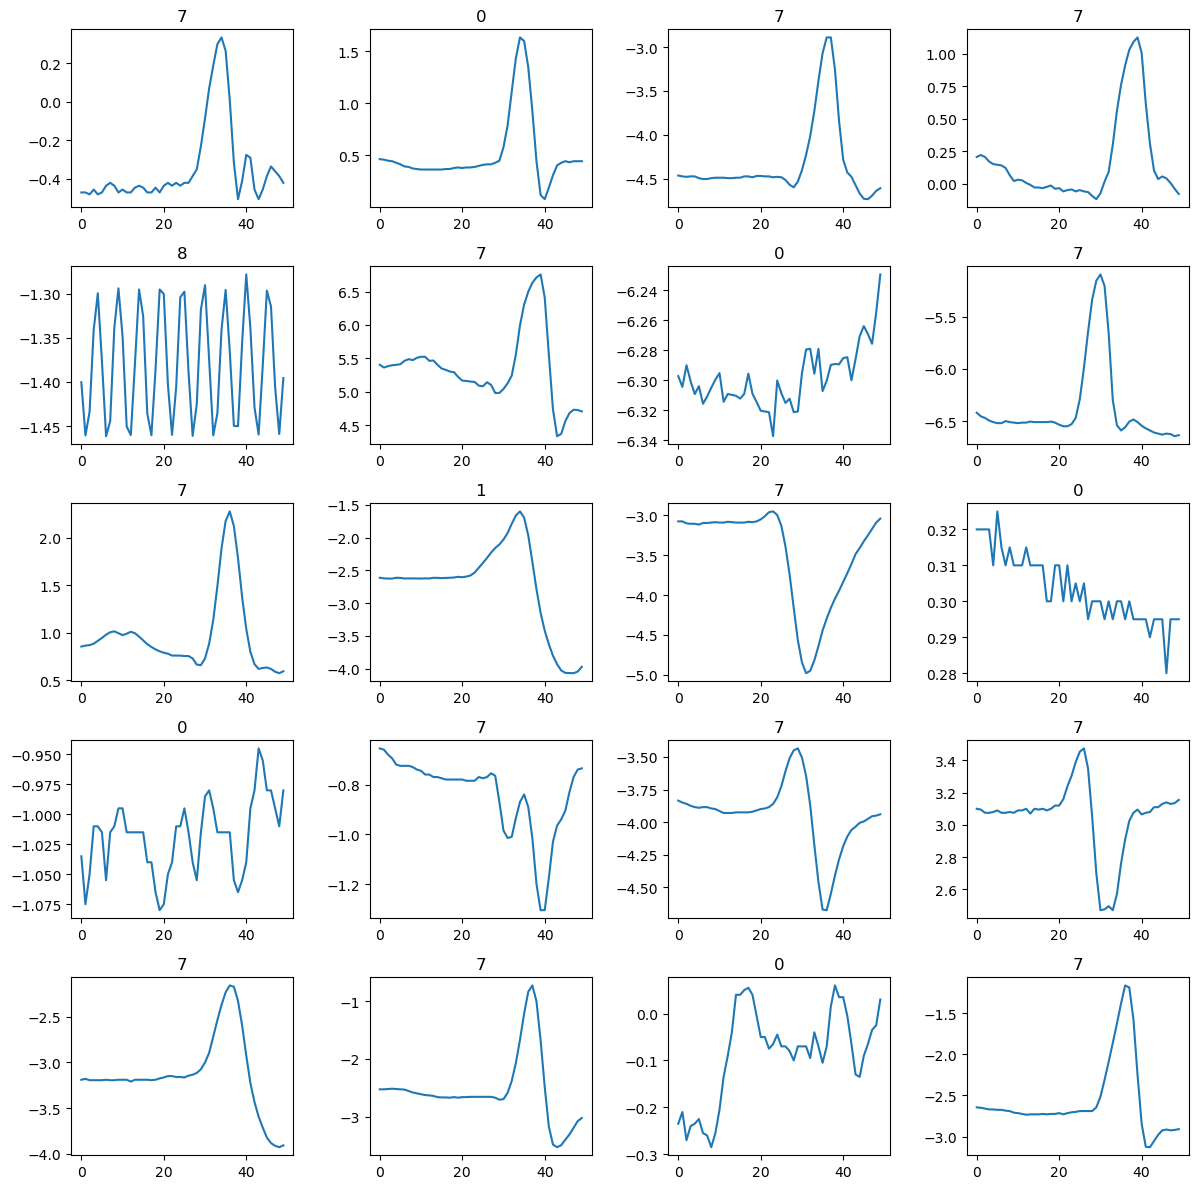

In [30]:
plt.figure(figsize=(12, 12))
for i in range(20):
    plt.subplot(5, 4, i + 1)
    plt.plot(Final_data.iloc[i,0])
    plt.title(Final_data.iloc[i,1])
plt.tight_layout()
plt.show()

spliting data

In [31]:
X_train ,X_test , X_valid , Y_train , Y_test , Y_valid = spliting_data(Final_data)

In [32]:
X_train
Y_train

array([1, 7, 0, ..., 7, 1, 1])

Training stage

In [33]:
LSTM_summary,LSTM_model , LSTM_hist_model=LSTM_model (X_train,Y_train , X_valid , Y_valid , symb_num ,epochs=30)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 50, 256)           133120    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 50, 256)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 50, 128)           164352    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 50, 128)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                        

In [34]:
RNN_summary,RNN_model , RNN_hist_model=RNN_model (X_train,Y_train , X_valid , Y_valid , symb_num,epochs=30)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 128)           16640     
                                                                 
 dropout_2 (Dropout)         (None, 50, 128)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 128)           32896     
                                                                 
 dropout_3 (Dropout)         (None, 50, 128)           0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 14)               

results representing

In [35]:
# Evaluate the model (RNN)
evaluate_model(RNN_model,X_test,Y_test)

343/343 [==============================] - 4s 11ms/step - loss: 0.5047 - accuracy: 0.8504
Test Accuracy: 85.04468202590942
Test Loss: 0.5046991109848022


In [36]:
# Evaluate the model (LSTM)
evaluate_model(LSTM_model,X_test,Y_test)

343/343 [==============================] - 12s 35ms/step - loss: 0.3532 - accuracy: 0.8839
Test Accuracy: 88.39139342308044
Test Loss: 0.35320571064949036


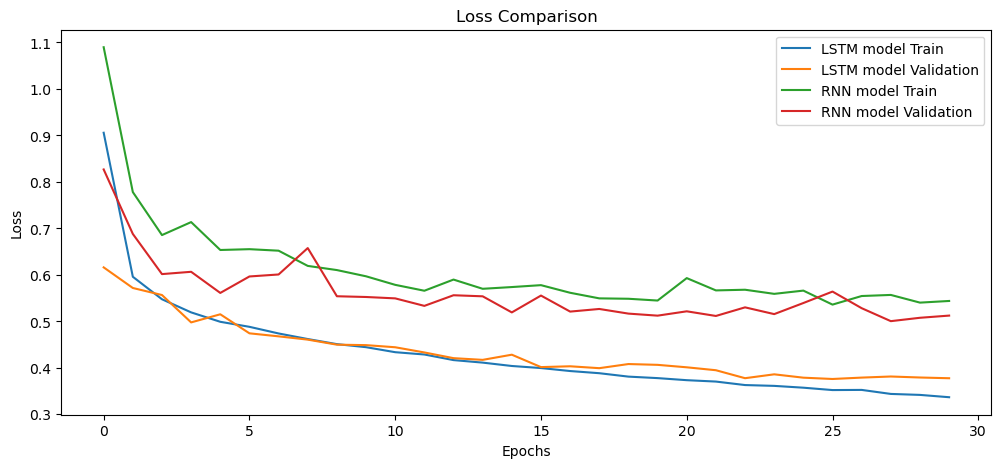

In [37]:
Loss_comp_graph(LSTM_hist_model,RNN_hist_model,'LSTM model','RNN model')

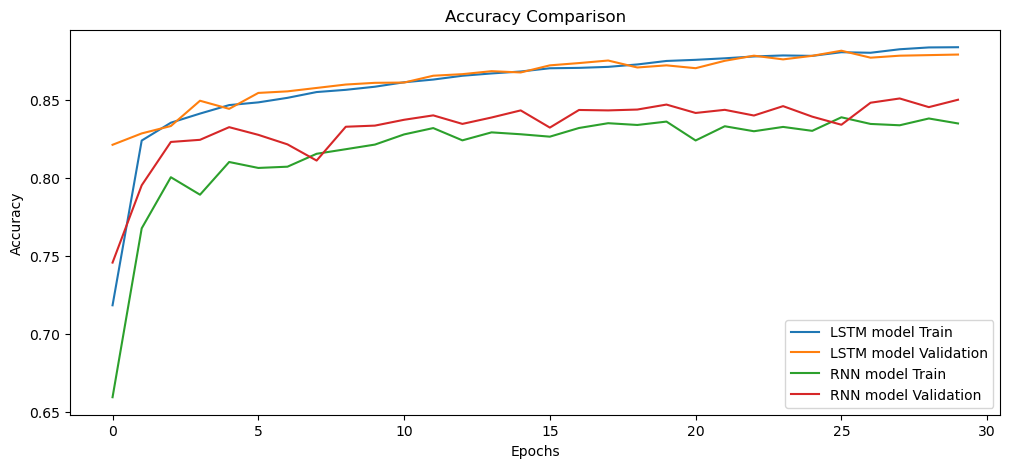

In [38]:
Accuracy_comp_graph(LSTM_hist_model,RNN_hist_model,'LSTM model','RNN model')

In [39]:
y_pred=predict(X_test=X_test,model=RNN_model,dic=annotations_dic)
y_pred

343/343 [==============================] - 4s 12ms/step


['~',
 'N',
 'N',
 'N',
 'N',
 '~',
 '~',
 'N',
 '~',
 'N',
 'V',
 'N',
 'N',
 'N',
 'V',
 'V',
 '~',
 'N',
 '~',
 'N',
 '~',
 'N',
 '~',
 'V',
 '~',
 '~',
 'N',
 '~',
 'N',
 'N',
 '~',
 'N',
 'N',
 'N',
 '~',
 '~',
 '~',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'V',
 'N',
 'N',
 's',
 'N',
 'N',
 '~',
 'N',
 '~',
 'N',
 '~',
 'N',
 'N',
 'N',
 'N',
 'N',
 '~',
 'N',
 'N',
 'N',
 '~',
 'N',
 '~',
 '~',
 '~',
 'N',
 'N',
 'N',
 'S',
 'N',
 'V',
 '~',
 'N',
 'N',
 '~',
 '~',
 'N',
 'N',
 '~',
 '~',
 'N',
 '~',
 'S',
 '~',
 'N',
 '~',
 'N',
 'N',
 'N',
 'V',
 'N',
 'N',
 'N',
 'N',
 '~',
 'N',
 'F',
 'V',
 'N',
 'N',
 'V',
 'N',
 '~',
 'V',
 'N',
 '~',
 '~',
 'V',
 'V',
 'N',
 'V',
 'N',
 'N',
 'N',
 'N',
 'N',
 '~',
 '~',
 '~',
 'N',
 'N',
 '~',
 'N',
 '~',
 'N',
 'N',
 'S',
 'N',
 '~',
 'V',
 'N',
 'N',
 'N',
 '~',
 '~',
 'N',
 'V',
 'V',
 'N',
 'N',
 '~',
 'N',
 'N',
 'N',
 'V',
 'N',
 '~',
 '~',
 '~',
 'V',
 '~',
 'N',
 'N',
 'N',
 'N',
 'N',
 '~',
 '~',
 'N',
 'V',
 '~',
 '~'

In [41]:
Y_test_decoder=decoder(labels=Y_test,dic=annotations_dic)
Y_test_decoder

['~',
 'N',
 'N',
 'V',
 'N',
 '~',
 '~',
 'N',
 '~',
 'N',
 'V',
 'N',
 'N',
 'N',
 'V',
 'V',
 '~',
 '~',
 '~',
 'N',
 '~',
 'N',
 '~',
 'V',
 '~',
 '~',
 'N',
 '~',
 'N',
 'N',
 'T',
 'N',
 'N',
 'N',
 '~',
 'T',
 '+',
 'N',
 '~',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'V',
 'N',
 'N',
 's',
 'N',
 'N',
 '~',
 'N',
 'T',
 'N',
 '~',
 'S',
 'N',
 'N',
 'N',
 'N',
 '~',
 'N',
 'N',
 'N',
 '~',
 'N',
 '~',
 '~',
 '~',
 'N',
 'N',
 'N',
 'S',
 'N',
 'V',
 '~',
 'N',
 'N',
 '~',
 '~',
 'N',
 'N',
 'T',
 '~',
 'N',
 '~',
 'S',
 '~',
 'N',
 '~',
 'N',
 'N',
 'N',
 'V',
 'N',
 'N',
 'N',
 'N',
 '~',
 'N',
 'F',
 'V',
 'N',
 'N',
 'V',
 'N',
 'T',
 'V',
 'N',
 '~',
 '~',
 'V',
 'F',
 'N',
 'F',
 'N',
 'N',
 'N',
 'N',
 'N',
 '~',
 '~',
 '~',
 'N',
 'N',
 'T',
 'N',
 'T',
 'N',
 'N',
 'S',
 'N',
 '~',
 'V',
 'N',
 'N',
 'N',
 '~',
 '~',
 'N',
 'V',
 'V',
 'N',
 'N',
 '~',
 'S',
 'N',
 'N',
 'V',
 'N',
 '~',
 'T',
 '~',
 'V',
 '~',
 'N',
 'N',
 'N',
 'N',
 'N',
 '~',
 '~',
 'N',
 'V',
 's',
 '~'

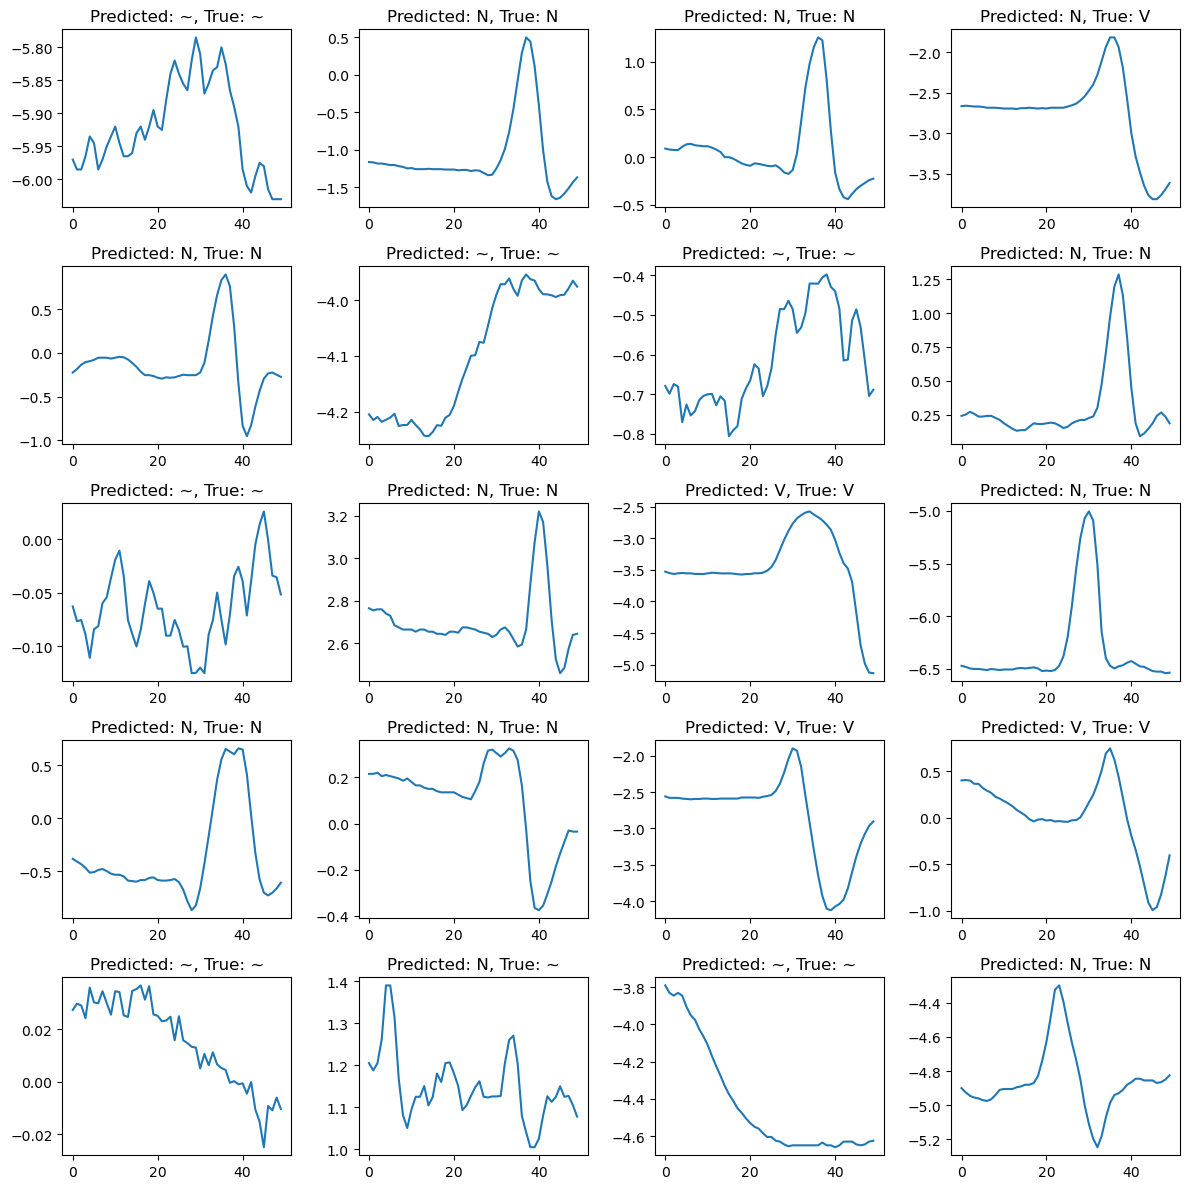

In [42]:
plt.figure(figsize=(12, 12))
for i in range(20):
    plt.subplot(5, 4, i + 1)
    plt.plot(X_test[i])
    plt.title(f"Predicted: {y_pred[i]}, True: {Y_test_decoder[i]}")
plt.tight_layout()
plt.show()

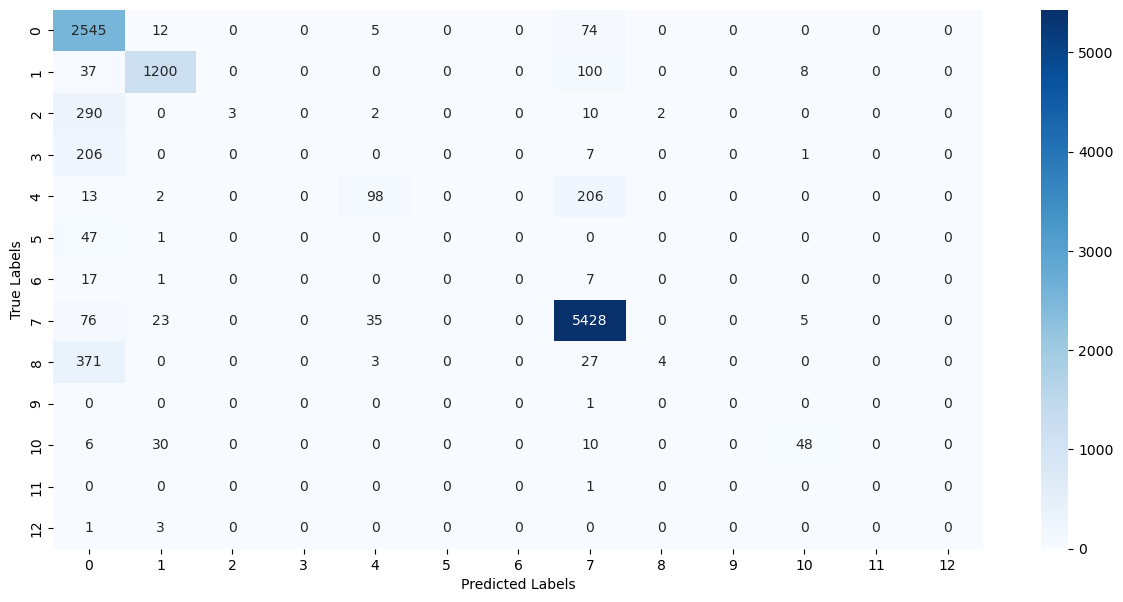

In [48]:
Y_pred_encoded = conf_mat(Y_test , y_pred,annotations_dic)

In [52]:
print(classification_report(Y_test,Y_pred_encoded))

              precision    recall  f1-score   support

           0       0.71      0.97      0.82      2636
           1       0.94      0.89      0.92      1345
           2       1.00      0.01      0.02       307
           3       0.00      0.00      0.00       214
           4       0.69      0.31      0.42       319
           5       0.00      0.00      0.00        48
           6       0.00      0.00      0.00        25
           7       0.92      0.98      0.95      5567
           8       0.67      0.01      0.02       405
           9       0.00      0.00      0.00         1
          10       0.77      0.51      0.62        94
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         4

    accuracy                           0.85     10966
   macro avg       0.44      0.28      0.29     10966
weighted avg       0.83      0.85      0.81     10966



D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
LSTM_model.save('D:/3rd Biomedical/2nd semister/LSTM_model.h5')

In [55]:
RNN_model.save('D:/3rd Biomedical/2nd semister/RNN_model.h5')

In [57]:
dec_annotations = decoder(annotations,annotations_dic)
dec_annotations

['+',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N'

In [60]:
make_df(beats,dec_annotations).to_csv('D:/3rd Biomedical/2nd semister/data.csv', index=False)